# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

# Table of Contents
1. [General Information](#step1)
2. [Analysis](#step2)
3. [Evaluation Procedure](#step3)
4. [Normalization](#step4)
5. [Train/Test split](#step5)
6. [Model Training](#step6)
7. [Testing Models on My Reviews](#step7)
8. [Conclusion](#step8)

## General Information<a name='step1'></a>

### Initialization

In [1]:
import math

import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
lemmatizer = WordNetLemmatizer()

In [2]:
#matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [4]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

### Load Data

We can now read the data

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


We can check the general information of our dataframe

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


Average rating and votes columns have 2 missing values each. We can drop these rows with missing values

In [7]:
df_reviews = df_reviews.dropna()
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47329 non-null object
title_type         47329 non-null object
primary_title      47329 non-null object
original_title     47329 non-null object
start_year         47329 non-null int64
end_year           47329 non-null object
runtime_minutes    47329 non-null object
is_adult           47329 non-null int64
genres             47329 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47329 non-null object
rating             47329 non-null int64
sp                 47329 non-null object
pos                47329 non-null int64
ds_part            47329 non-null object
idx                47329 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.5+ MB


No more missing values. We can now check for row duplicates

In [8]:
df_reviews.duplicated().sum()

0

No row duplicates. We can now check the balance of the classes in our target (the 'pos' column). We can plot a histogram for that.

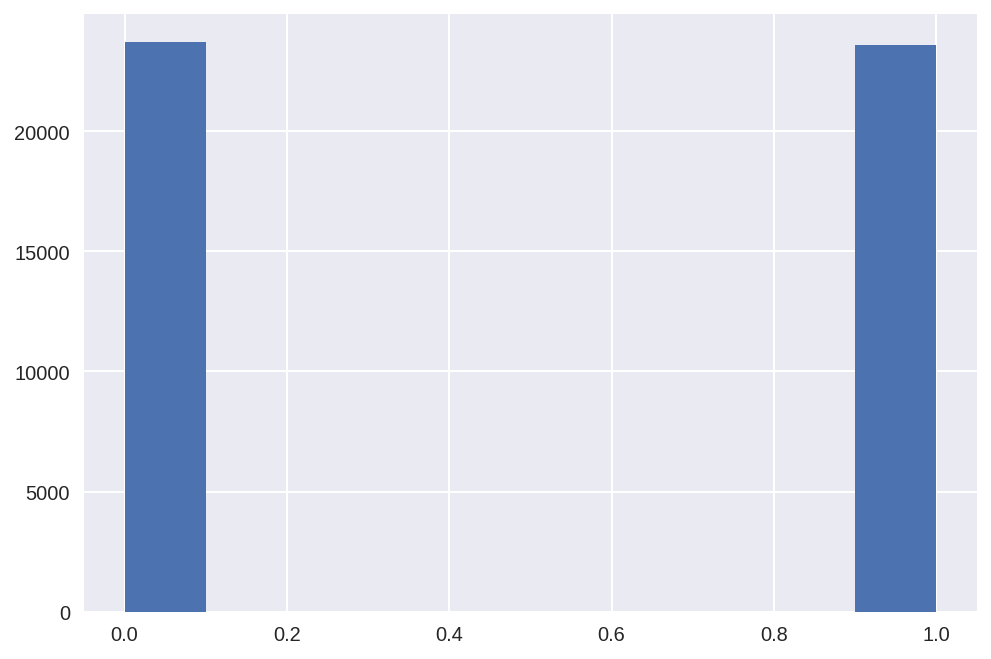

In [9]:
df_reviews['pos'].hist()
plt.show()

Throughout the dataset, the classes (0 and 1) are balanced

## Analysis<a name='step2'></a>

Let's check the number of movies and reviews over years.

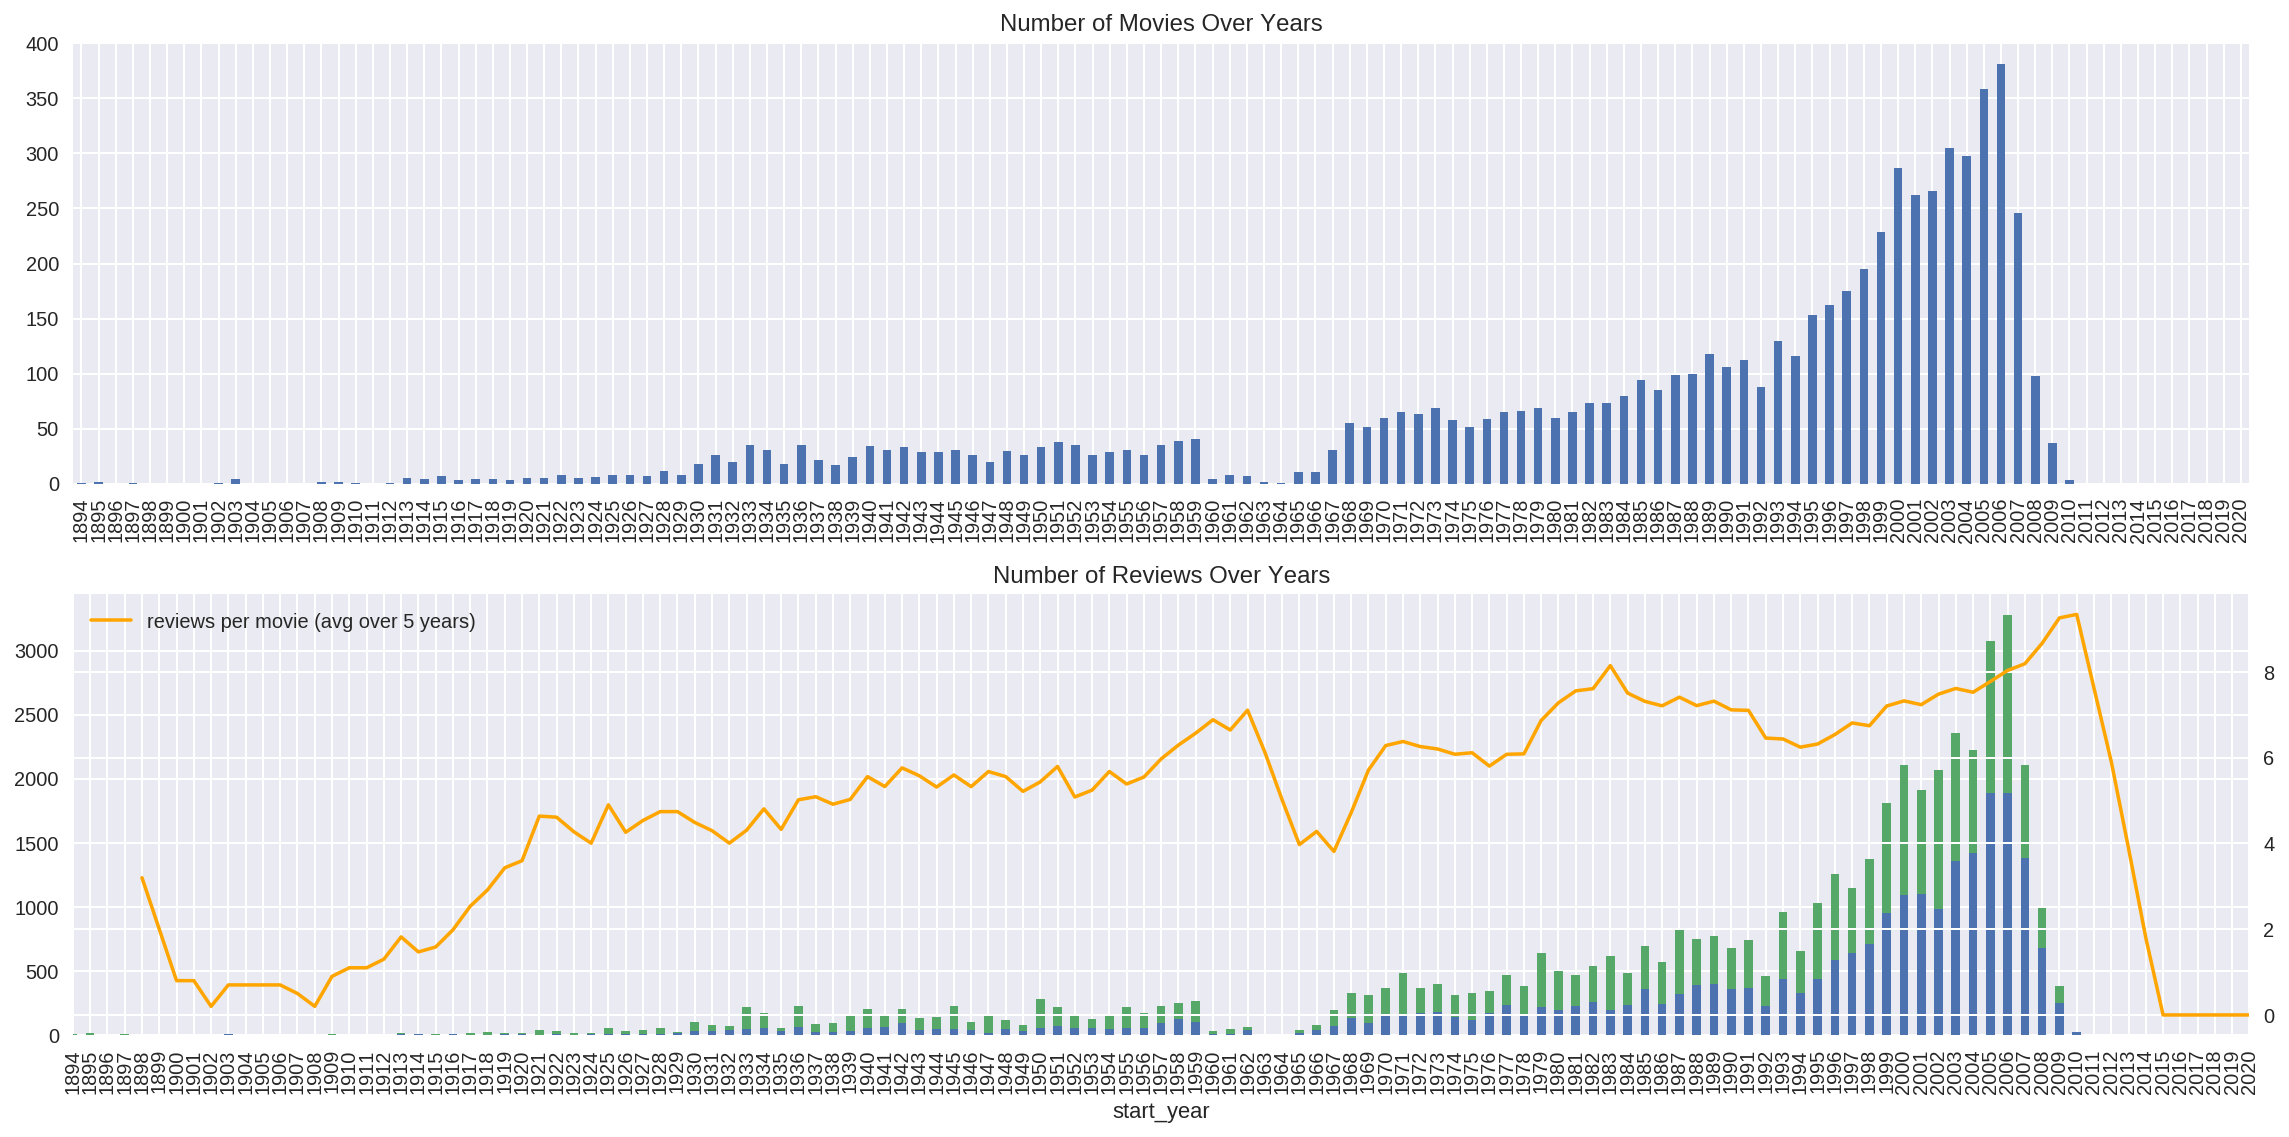

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We observe an overall increase in number of movies peaking at 2006, then drops after that. Same as the number of reviews per movie.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

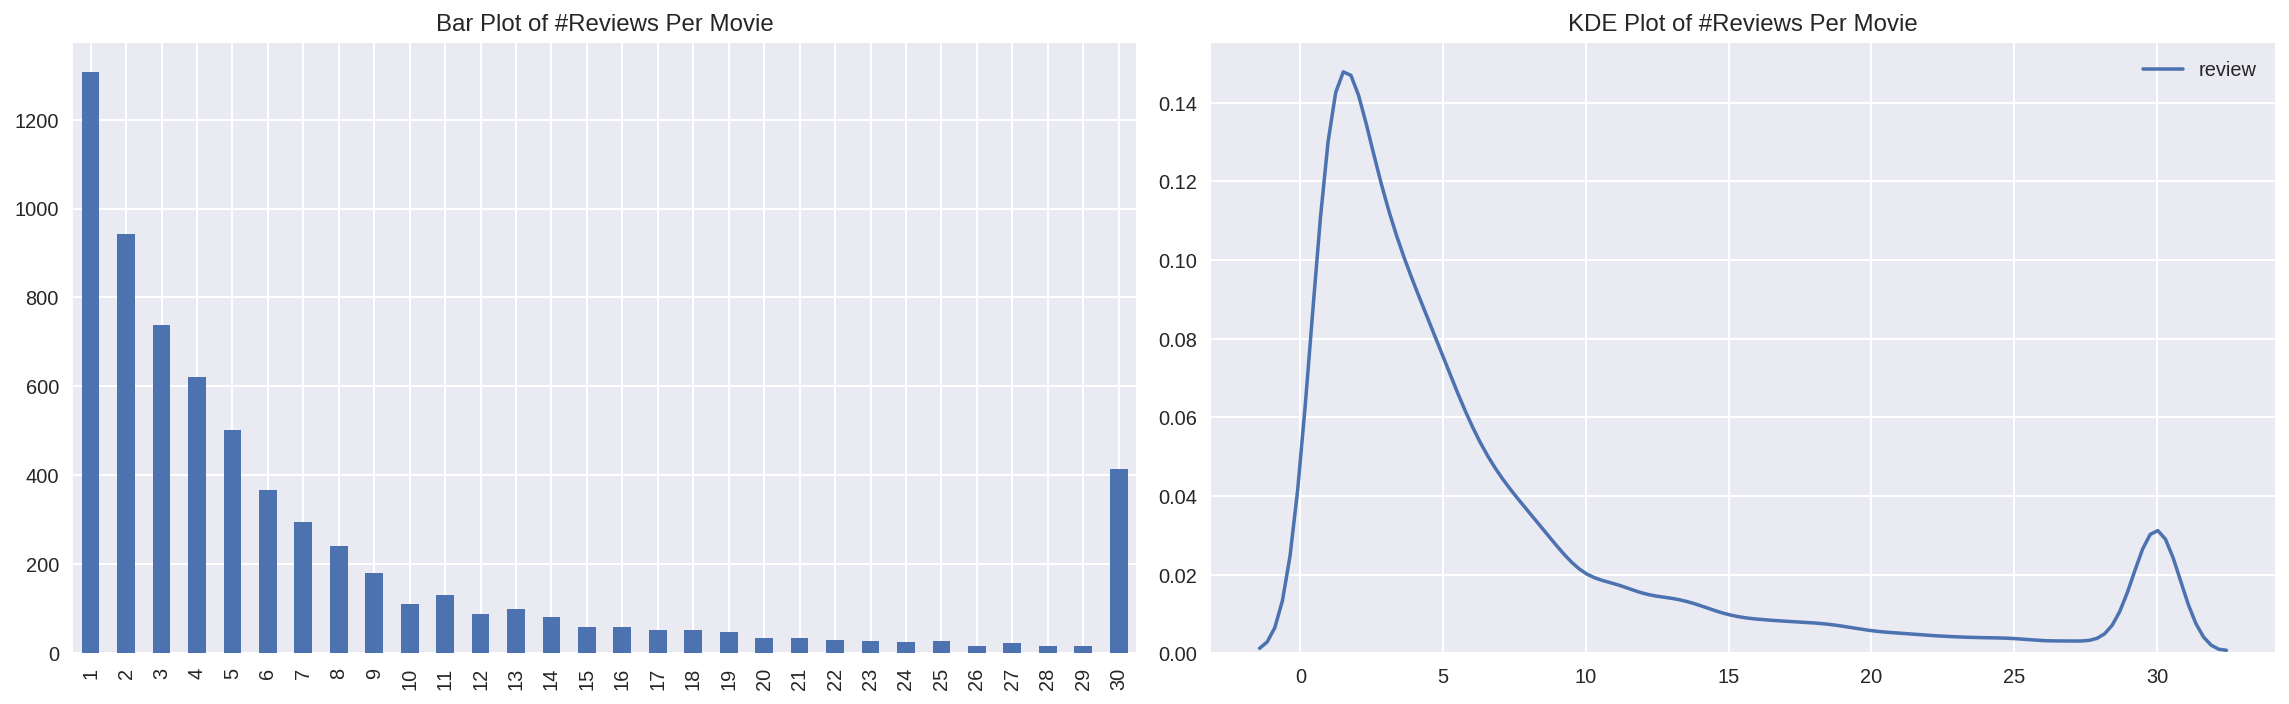

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

There are a lot more movies with 1 review, and we observe a steady decrease as the number of reviews increase, then a sudden uptick at 30 reviews. Let us now see the distribution of ratings in both training and test sets

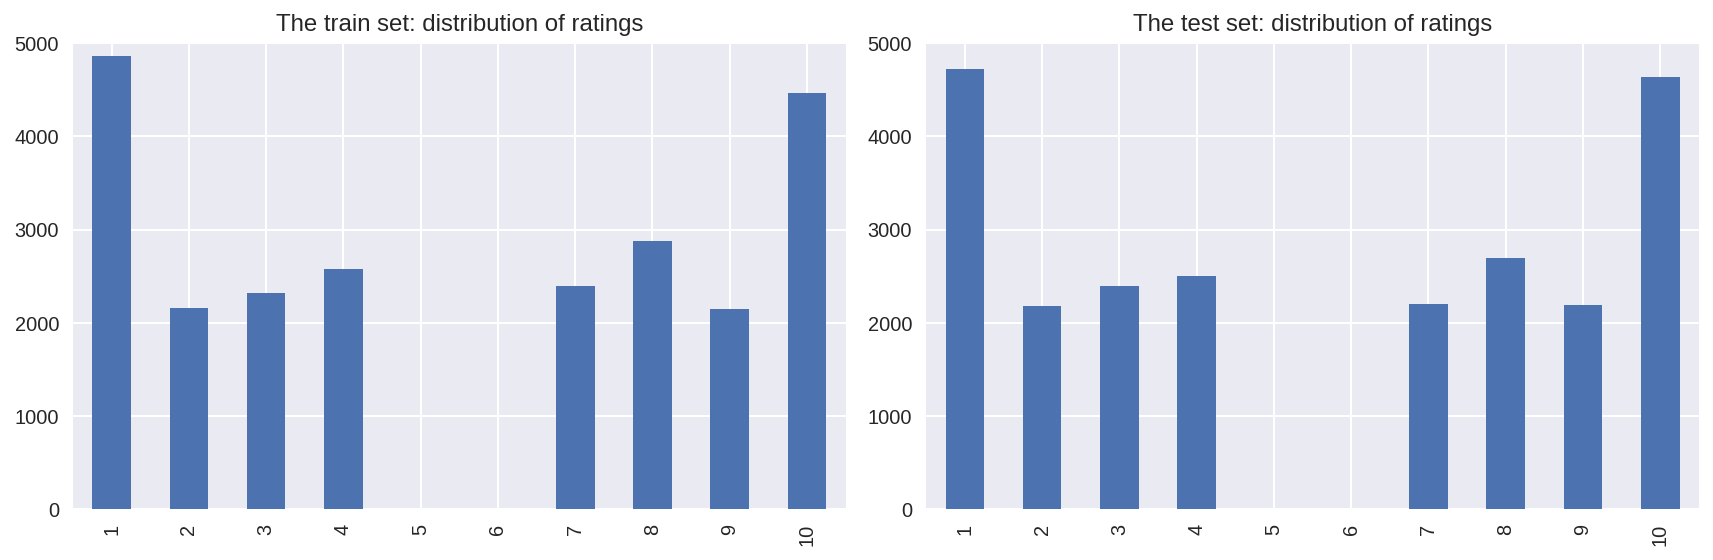

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

There a lot of reviews that give a rating of 1, closely followed by those with a rating of 10. There is not much difference between the number of reviews that give a 2, 3, or 4 and those giving 7, 8, or 9. There are very few 5 or 6 ratings

Distribution of negative and positive reviews over the years for two parts of the dataset

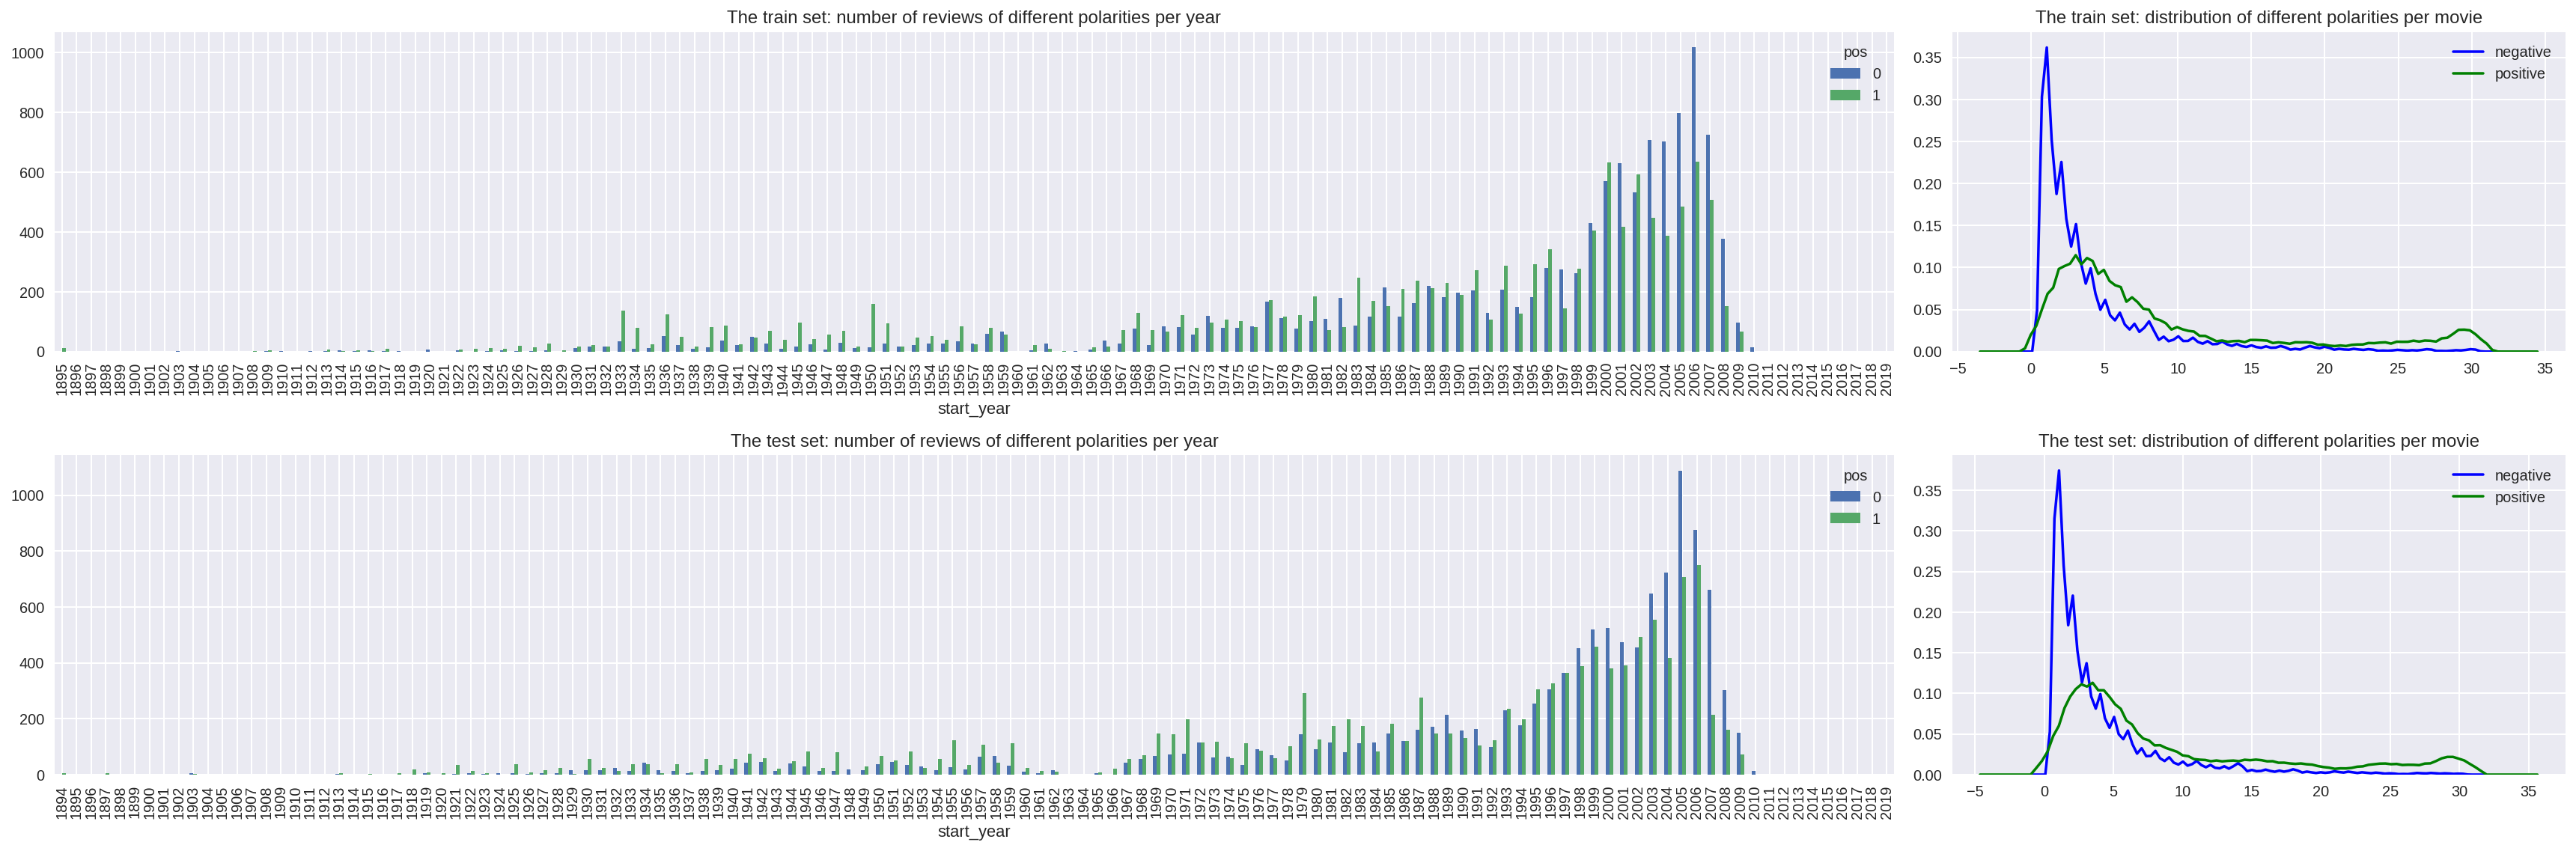

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(24, 8), gridspec_kw=dict(width_ratios=(3, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=False, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=False, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

For the vast majority of the years, the negative reviews have outnumbered the positive reviews 

## Evaluation Procedure<a name='step3'></a>

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization<a name='step4'></a>

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
#normalization i.e lowercase, alphabet-only text
df_reviews['review_norm']=df_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())
df_reviews['review_norm']=df_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Train / Test Split<a name='step5'></a>

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
#Getting training and test sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']


print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models<a name='step6'></a>

### Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier
stop=set(stopwords.words('english'))

In [18]:
#Getting geatures using lemmatization
f_train0=[]
f_test0=[]
for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_train0.append(l_join)

for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_test0.append(l_join)

#training the model    
model=DummyClassifier().fit(f_train0, train_target)

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


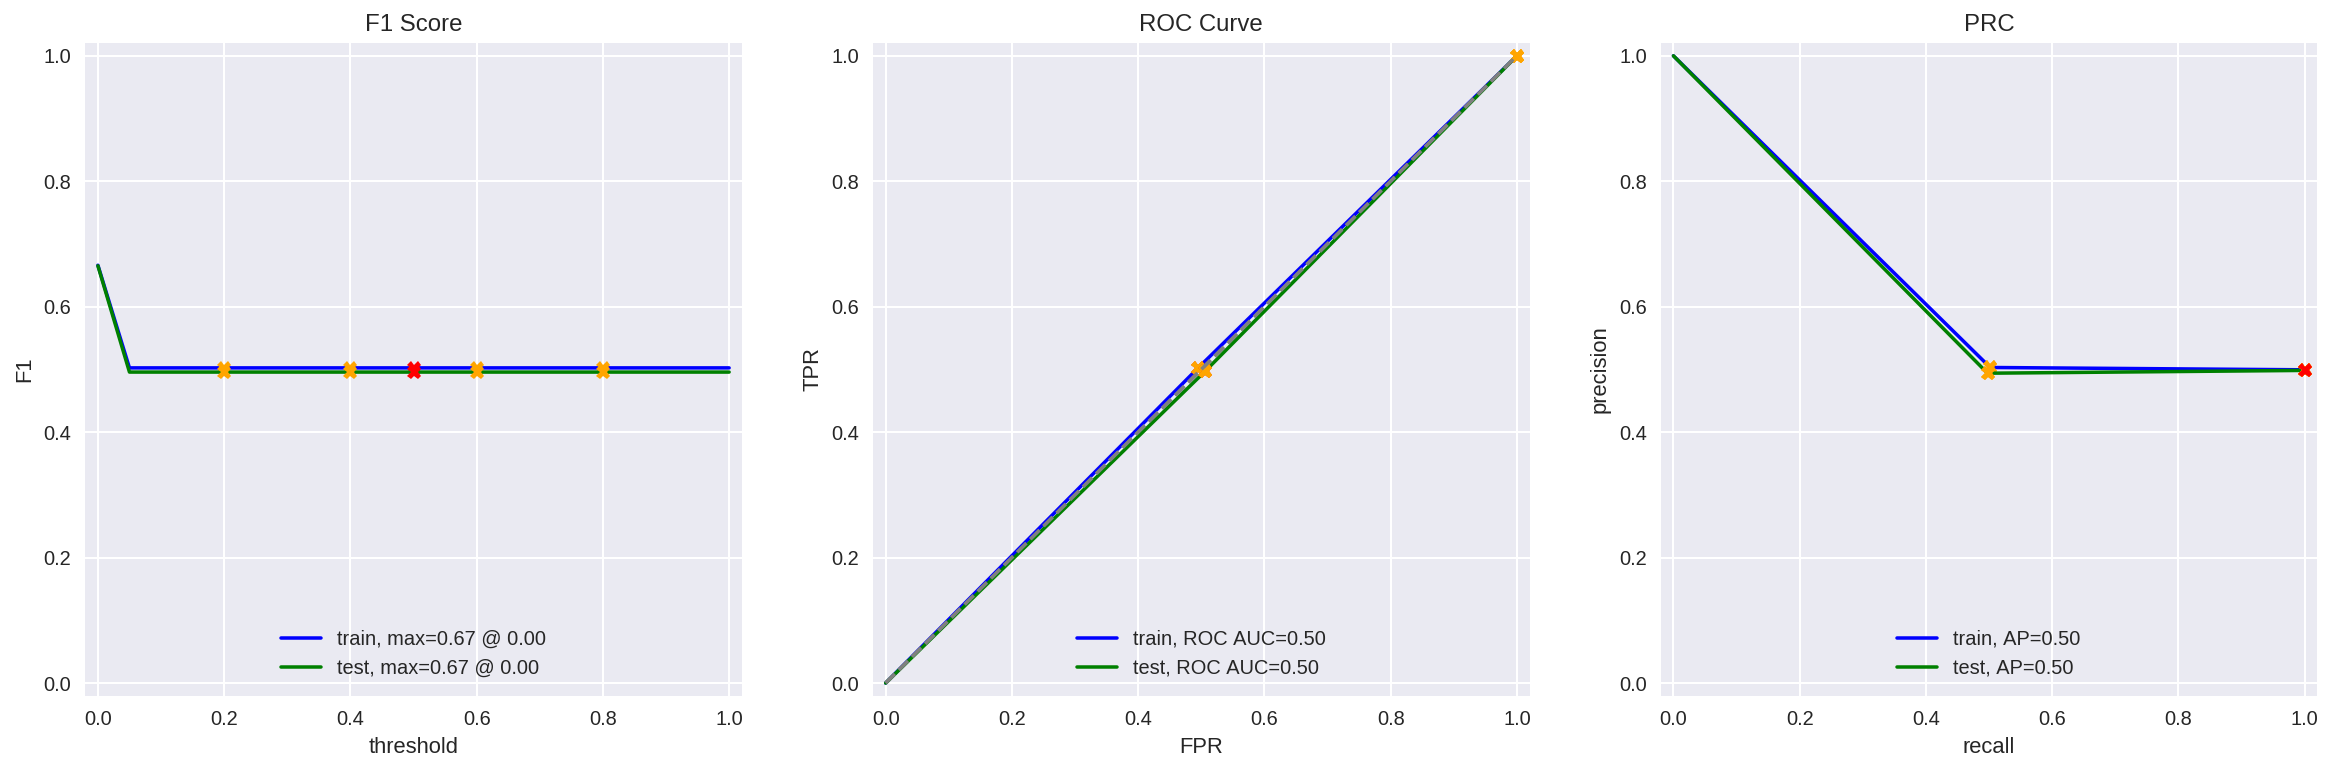

In [19]:
evaluate_model(model, f_train0, train_target, f_test0, test_target)

Our F1 score for the test set is 0.5. Our subsequent models need to do better

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

Let us get our features

In [21]:
corpus_train=[]
corpus_test=[]

In [22]:
#Training corpus
for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    corpus_train.append(l_join)

In [23]:
#Test corpus
for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    corpus_test.append(l_join)

In [24]:
#Vectorizing the corpuses with the TF-IDF Vectorizer, indicating english stopwords and unigrams
count_tf_idf2=TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,1))
train_features_1 = count_tf_idf2.fit_transform(corpus_train)
test_features_1 = count_tf_idf2.transform(corpus_test)

Training the model...

In [25]:
model_1 = LogisticRegression(C=0.5).fit(train_features_1, train_target)

Evaluating the model using the evaluation routine...

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


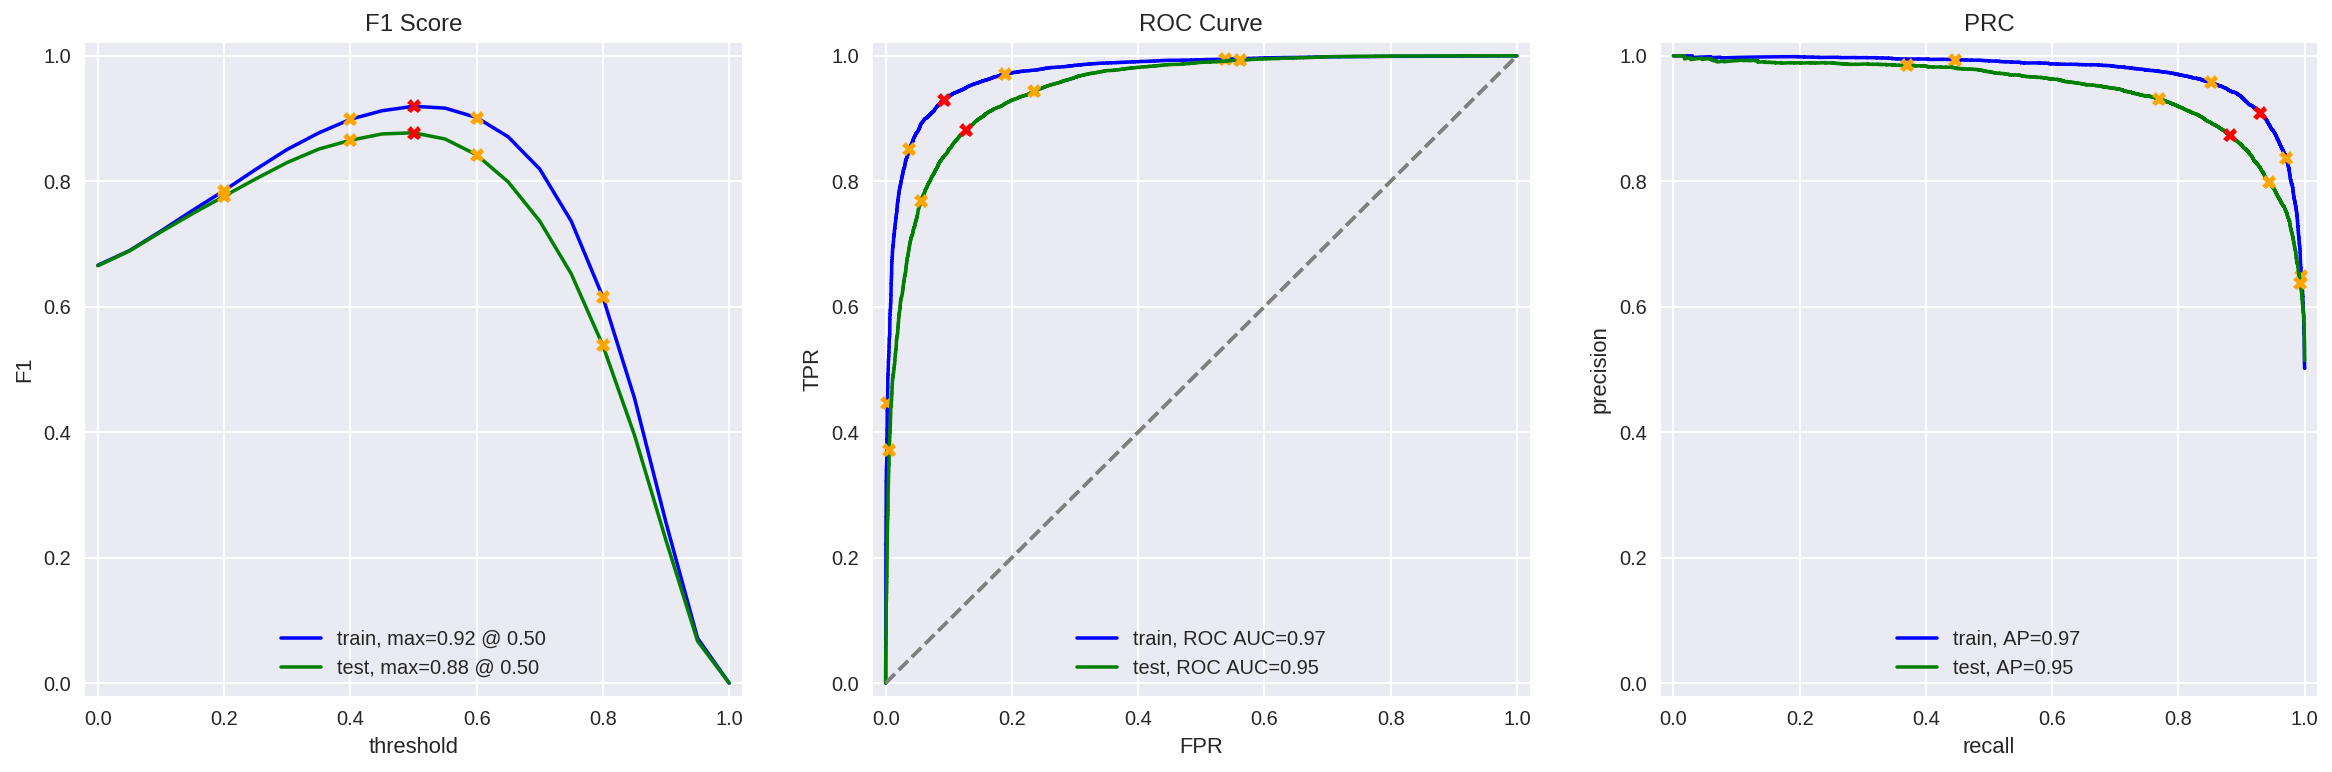

In [26]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

F1 score for the test set is 0.88 which is much better than the dummy classifier and above our minimum requirement

### Model 3 - spaCy, TF-IDF and LR

Using spaCy...

In [27]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [28]:
#Function that processes, lemmatizes the text
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [29]:
#Getting the features
c_train3=[]
c_test3=[]

#Training corpus
for text in df_reviews_train['review_norm']:
    result=text_preprocessing_3(text)
    c_train3.append(result)

#Test corpus
for text in df_reviews_test['review_norm']:
    result=text_preprocessing_3(text)
    c_test3.append(result)

#Vectorizing the corpuses    
count_tf_idf3=TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,1))
f_train3 = count_tf_idf3.fit_transform(c_train3)
f_test3 = count_tf_idf3.transform(c_test3)

Training the model...

In [30]:
model_3=LogisticRegression(C=0.5).fit(f_train3, train_target)

Model evaluation...

          train  test
Accuracy   0.91  0.87
F1         0.92  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


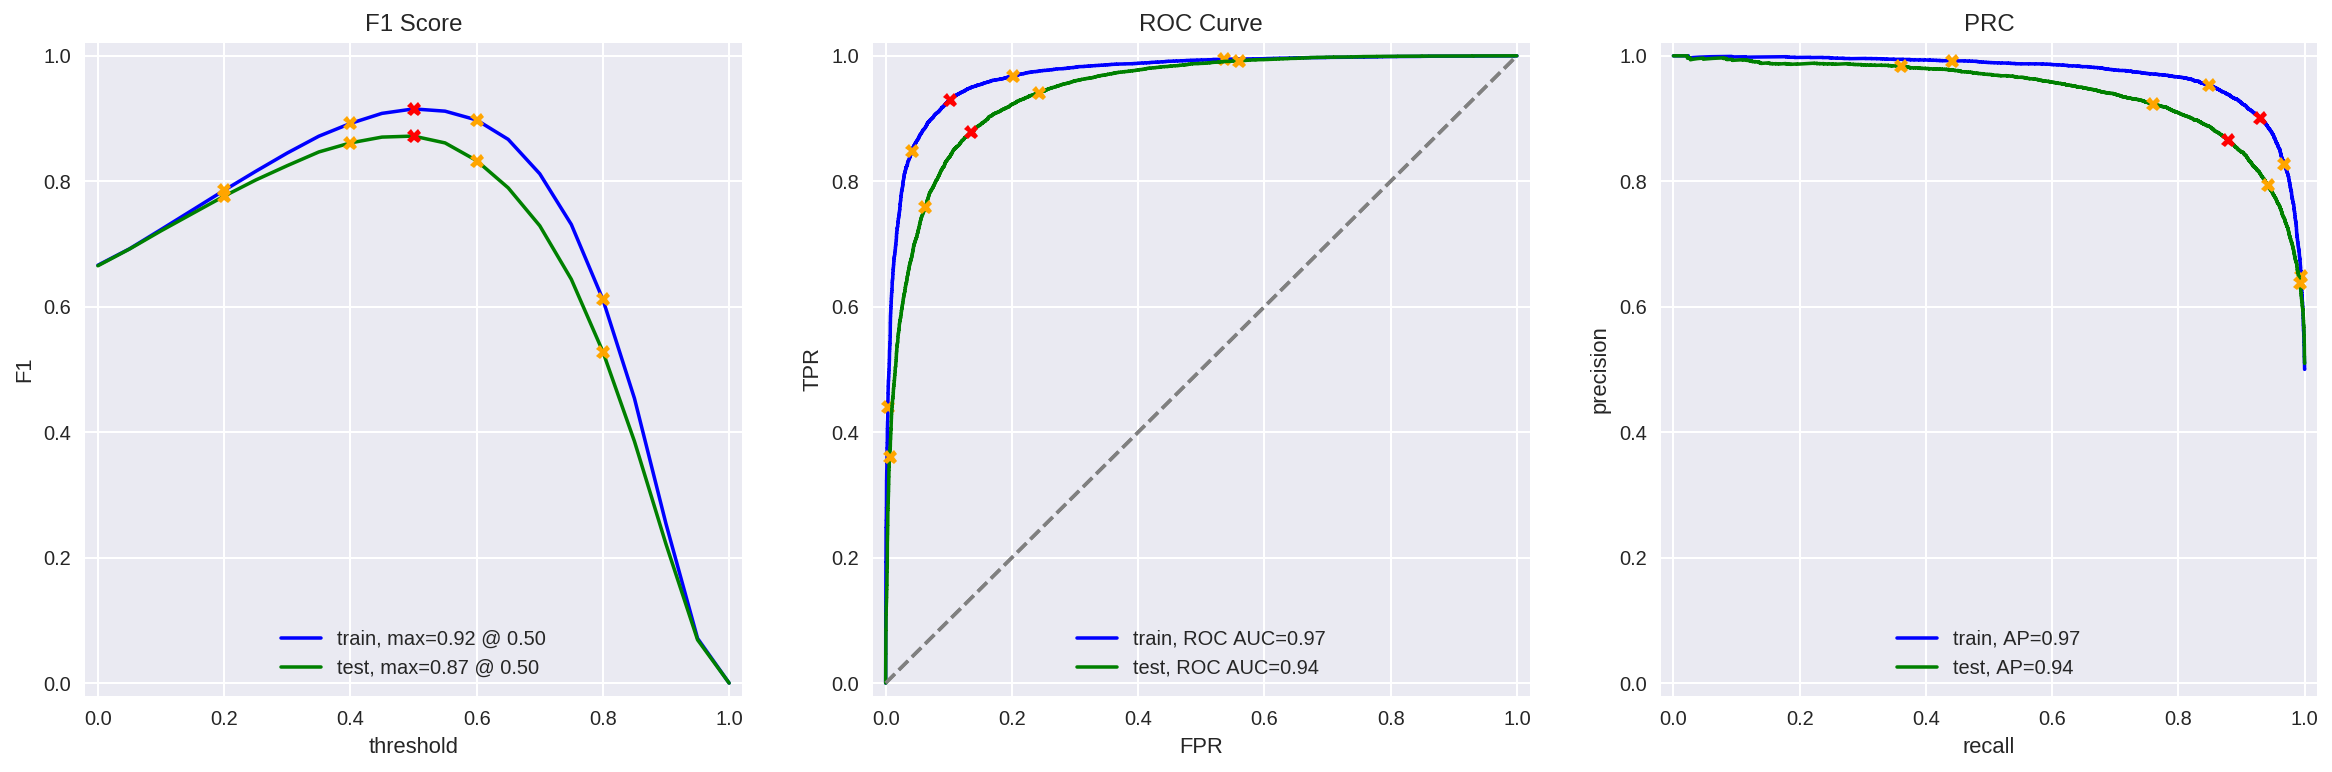

In [31]:
evaluate_model(model_3, f_train3, train_target, f_test3, test_target)

F1 score for the test set is 0.87 (a little less than the previous but still over the minimum requirement)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

Since we are still using spaCy and TF-IDF, we can use the vectorized values we got from the last model. We will look for the best parameters with which to train the LightGBM classifier model 

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [33]:
#Finding the best parameters for the LightGBM Classifier model
model=LGBMClassifier()
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['binary'],
            'random_state':[12345]}
grid=GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train3, train_target)
best_param=grid.best_params_

In [34]:
print('Best score from searched params:', grid.best_score_)
print('Best parameters:', best_param)

Best score from searched params: 0.835529525542419
Best parameters: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'objective': 'binary', 'random_state': 12345}


In [35]:
#train, test using the best parameters
model_4=LGBMClassifier(num_leaves=best_param['num_leaves'],
                      learning_rate=best_param['learning_rate'],
                      n_estimators=best_param['n_estimators'],
                      objective='binary',
                      random_state=12345)
model_4.fit(f_train3, train_target)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=20, n_jobs=-1, num_leaves=30, objective='binary',
               random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Model evaluation....

          train  test
Accuracy   0.90  0.84
F1         0.90  0.84
APS        0.96  0.92
ROC AUC    0.96  0.92


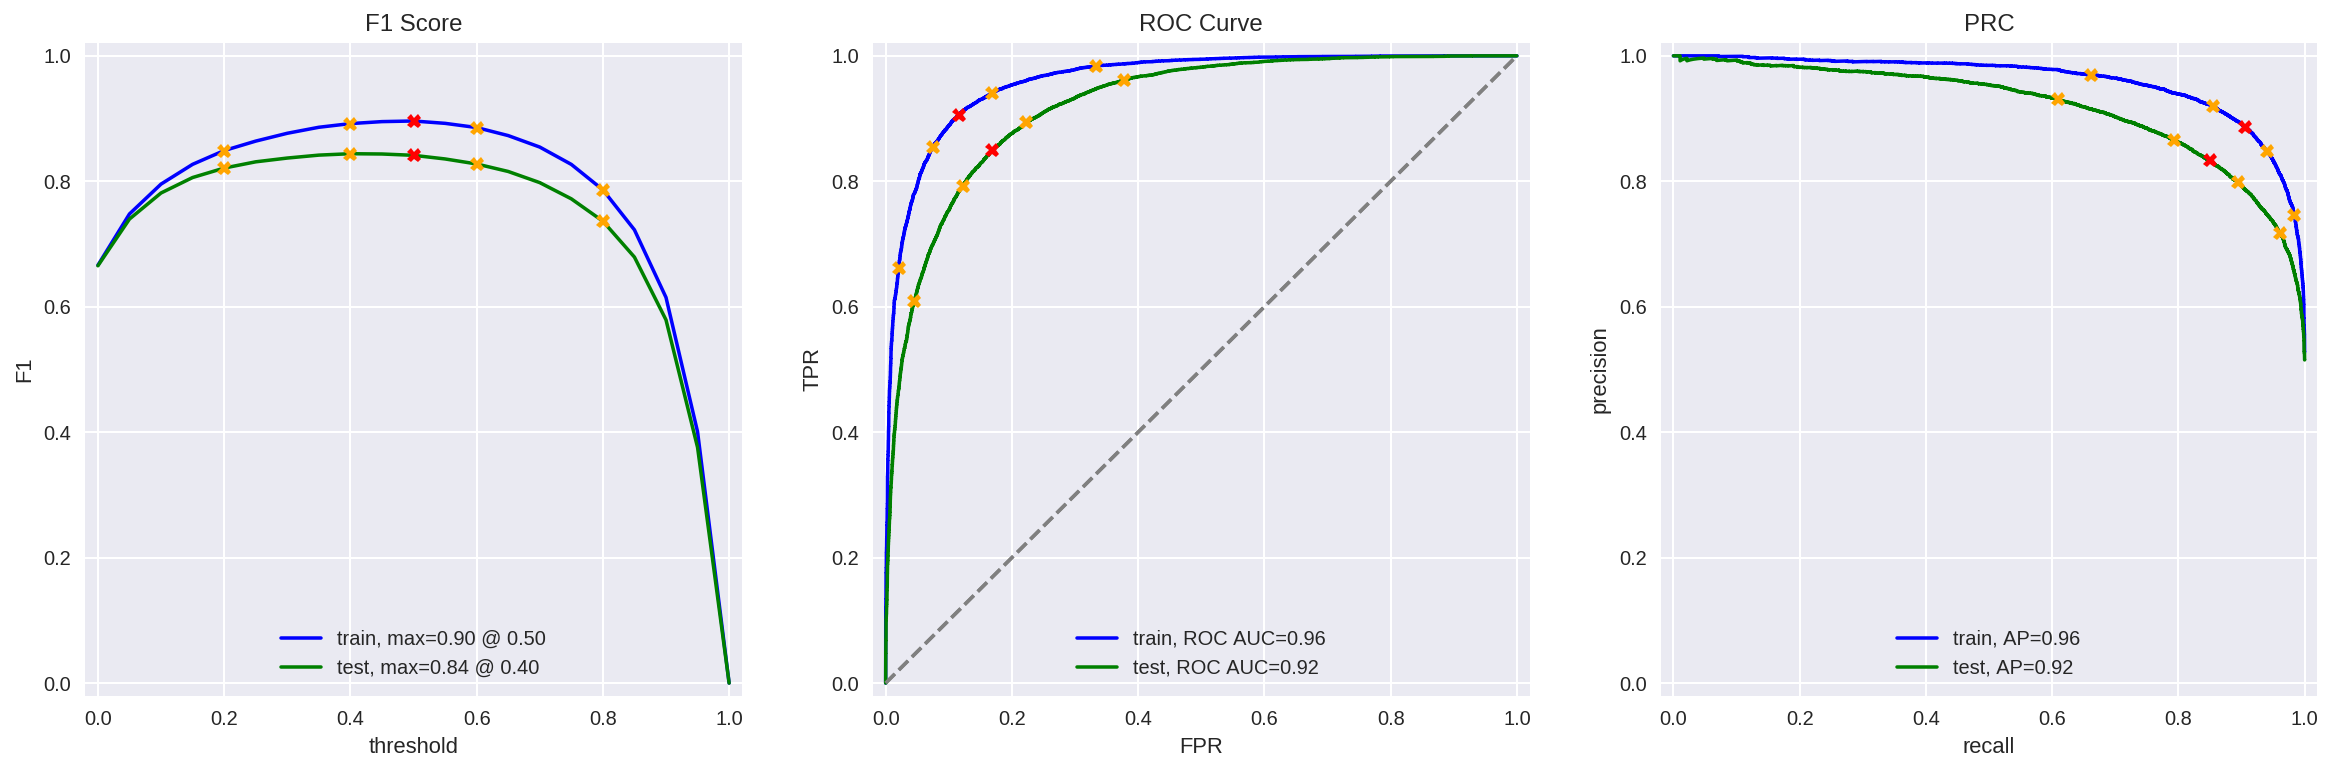

In [36]:
evaluate_model(model_4, f_train3, train_target, f_test3, test_target)

F1 score is 0.84, a little under the minimum requirement

## Testing the models on my reviews<a name='step7'></a>

In [37]:
#creating a datgaframe with reviews then creating a column with the normalized reviews

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


The 1st, 2nd, 4th, and 7th reviews are negative. The 3rd, 5th, 6th, and 8th reviews are positive

### Model 2

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.28:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.20:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.42:  i didn t expect the reboot to be so good writers really cared about the source material
0.46:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


It gives lower positivity probabilities for the 5th and 6th reviews, which are positive

### Model 3

In [39]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.11:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.22:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.38:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.86:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


This model was more likely to give negative ratings than positive ratings, since it got all the negative review probabilities right and the positive review probabilities wrong except for the last review.

### Model 4

In [40]:
texts = my_reviews['review_norm']


my_reviews_pred_prob = model_4.predict_proba(count_tf_idf3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.61:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.36:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.67:  i didn t expect the reboot to be so good writers really cared about the source material
0.58:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.43:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.75:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


This model got only 1 probability wrong, the 1st review. And this model is not as extreme as the others. The max probability here 75%, compared to 86% and 84% for the others

## Conclusions<a name='step8'></a>

We analyzed the data and saw that there was an overall increase in number of movies per year peaking at 2006 then decreasing. We saw that, generally, fewer movies had more reviews and that there were more negative reviews per year than positive reviews. We trained models to predict whether a review would be positive or negative. The model with the best F1 score was the Logistic Regression model which used NLTK processing and the TF-IDF Vectorizer (F1 score of 0.88). We did not train a BERT model since we didn't have enough processing power